# __Reconstruction__
1) Class for puzzle pieces
2) Append the puzzle pieces to an array of puzzlePiece objects
3) Create a canvas
4) Paste the pieces to a canvas

## puzzlePiece class
Edge list: left,bottom,right,top

In [104]:
import cv2
import matplotlib.pyplot as plt

class puzzlePiece:
    def __init__(self, piece_id, contour, peaks_ids, center, angles, distances):
        self.piece_id = piece_id
        self.contour = contour
        self.corners = peaks_ids
        self.center = center
        self.contour_polar = (angles, distances)
        self.edges = []
        self.path = ""
        self.piece_type = ""

    def set_sides(self) -> None:
        """Sets the sides of the piece based on the edges."""
        if self.edges is not None:
            self.left = self.edges[0]
            self.bottom = self.edges[1]
            self.right = self.edges[2]
            self.top = self.edges[3]

    def get_piece_type(self) -> str:
        """Returns the type of the piece based on the number of edges."""
        if self.edges is not None:
            flat_edges_count = sum(1 for edge in self.edges if edge[3] == 0)

            match flat_edges_count:
                case 0: self.piece_type = "Middle"
                case 1: self.piece_type = "Border"
                case 2: self.piece_type = "Corner"

            return self.piece_type
    
    def rotate(self) -> None:
        "Rotates the piece by 90 degrees"
        piece = cv2.imread(self.path, cv2.IMREAD_UNCHANGED)
        piece = cv2.rotate(piece, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(self.path, piece)

        self.set_sides()
        # Reassign sides
        self.left, self.bottom, self.right, self.top = (
        self.top, self.left, self.bottom, self.right
        )


    def __repr__(self):
        ret = ""
        ret += f"{self.piece_id}\n"
        """ret += f"Contour: {len(self.contour)}\n"
        ret += f"Corners: {self.corners}\n"
        ret += f"Edges: {self.edges}\n"
        ret += f"Type: {self.get_piece_type()}\n"""

        return ret
       

## Populating the pieces array

In [105]:
#!/usr/bin/env python
# coding: utf-8

# In[94]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import math
import bisect


# ### Default image path
image_path = "images/hack2.png"


def display_image(title, image):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2 or image.shape[2] == 1:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()


# ## Basic reading image and display

# In[97]:

original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if original_image is None:
    raise ValueError(f"Could not read image from {image_path}")


# ## Grayscale conversion

# In[98]:

gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
# display_image("Grayscale Image", gray_image)


print("Threshold to separate pieces from background")
_, binary_image = cv2.threshold(gray_image, 30, 255, cv2.THRESH_BINARY)
# display_image("Binary Image", binary_image)


kernel = np.ones((12, 12), np.uint8)


# In[101]:


# Close = filling the holes
morph_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
# Open = removing the noise
morph_image = cv2.morphologyEx(morph_image, cv2.MORPH_OPEN, kernel)
# display_image("Morph Operations", morph_image)


# In[102]:


# print("Filling holes in puzzle pieces")
contours_fill, _ = cv2.findContours(morph_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours_fill:
    cv2.drawContours(morph_image, [cnt], 0, 255, -1)
# display_image("Filled Holes", morph_image)


# ## Contours finding

# In[103]:


contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# print(f"Found {len(contours)} potential puzzle pieces")


# In[104]:


# print("Filtering contours by size")
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
if len(contours) > 1:
    reference_area = cv2.contourArea(contours[1])
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > reference_area / 3]
# print(f"After filtering: {len(contours)} puzzle pieces")

# In[105]:

# print("Drawing contours of the original image")
contour_image = original_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)


# In[106]:

output_folder_pieces = "images/extracted_pieces"
os.makedirs(output_folder_pieces, exist_ok=True)

output_folder_contours = "images/extracted_contours"
os.makedirs(output_folder_contours, exist_ok=True)

output_corner_folder = "images/extracted_corners"
os.makedirs(output_corner_folder, exist_ok=True)

output_plots_folder = "images/corner_plots"
os.makedirs(output_plots_folder, exist_ok=True)

output_edges_and_corner_folder = "images/edges_and_corners"
os.makedirs(output_edges_and_corner_folder, exist_ok=True)

# In[107]:

piece_images = []
for i, contour in enumerate(contours):
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], 0, 255, -1)

    piece = np.zeros_like(original_image)
    piece[mask == 255] = original_image[mask == 255]

    x, y, w, h = cv2.boundingRect(contour)
    cropped_piece = piece[y:y + h, x:x + w]
    piece_images.append(cropped_piece)

    piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
    cv2.imwrite(piece_path, cropped_piece)

    # Save piece with contour
    contour_piece = cropped_piece.copy()
    mask_cropped = mask[y:y + h, x:x + w]
    cv2.drawContours(contour_piece, [contour - [x, y]], 0, (255, 0, 255), 1,
                     cv2.LINE_8)  # Pink, width 1, no anti-aliasing
    contour_path = os.path.join(output_folder_contours, f"contour_{i + 1}.png")
    cv2.imwrite(contour_path, contour_piece)


puzzle_piece_holder = []

for contours_indices in range(len(contours)):

    # In[108]:
    selected_image_index = contours_indices


    # In[109]:
    piece_images = []

    i = selected_image_index
    contour = contours[i]

    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], 0, 255, -1)

    piece = np.zeros_like(original_image)
    piece[mask == 255] = original_image[mask == 255]
    x, y, w, h = cv2.boundingRect(contour)
    cropped_piece = piece[y:y + h, x:x + w]
    piece_images.append(cropped_piece)

    piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
    cv2.imwrite(piece_path, cropped_piece)
    contour_piece = cropped_piece.copy()

    # display_image(f"Cropped piece {selected_image_index+1}", contour_piece)


    # In[110]:
    M = cv2.moments(contour)

    if M["m00"] == 0:
        print("ERROR")
    centroid_x = int(M["m10"] / M["m00"])
    centroid_y = int(M["m01"] / M["m00"])
    cv2.circle(contour_piece, (centroid_x - x, centroid_y - y), 2, (0, 0, 255), -1)
    # display_image(f"Centroid {i+1}", contour_piece)

    # In[113]:
    contour_points = contour - np.array([x, y])
    distances = []
    angles = []
    for point in contour:
        px, py = point[0]
        dx = px - centroid_x
        dy = py - centroid_y
        distance = np.sqrt(dx ** 2 + dy ** 2)
        angle = np.arctan2(dy, dx)
        distances.append(distance)
        angles.append(angle)

    angles_deg = np.array([(a * 180 / np.pi) % 360 for a in angles])

    distances = gaussian_filter1d(distances, sigma=2)
    delta_s = len(angles_deg) // 4

    angles_deg_s = np.roll(angles_deg, -delta_s)
    distances_s = np.roll(distances, -delta_s)

    # find the maxima
    min_distance_between_peaks = len(distances) // 20
    all_peak_indices, all_peak_properties = find_peaks(distances,                                 distance=min_distance_between_peaks,prominence=2)

    all_peak_indices_s, all_peak_properties_s = find_peaks(distances_s,                                 distance=min_distance_between_peaks,prominence=2)
    all_peak_indices_u = [(x+delta_s)%len(angles_deg) for x in all_peak_indices_s]
    all_peak_indices_f = [y for y in all_peak_indices_u if y not in all_peak_indices]

    for val in all_peak_indices_f:
        pos = np.searchsorted(all_peak_indices, val)
        all_peak_indices = np.insert(all_peak_indices, pos, val)

    # print(all_peak_properties)
    peak_angles = [angles_deg[peak_idx] for peak_idx in all_peak_indices]
    peak_distances = [distances[peak_idx] for peak_idx in all_peak_indices]

    # find the minima
    inverted_distances = [-d for d in distances]
    all_min_indices, all_min_properties = find_peaks(inverted_distances,
                                     distance=min_distance_between_peaks,prominence=0.1)

    min_angles = [angles_deg[min_idx] for min_idx in all_min_indices]
    min_distances = [distances[min_idx] for min_idx in all_min_indices]

    min_distances_avg = np.mean(min_distances)


    # In[122]:

    max_angle_diff = 25
    delCounter = 0

    remaining_peak_indices = all_peak_indices.tolist() if isinstance(all_peak_indices, np.ndarray) else all_peak_indices.copy()
    remaining_peak_angles = peak_angles.tolist() if isinstance(peak_angles, np.ndarray) else peak_angles.copy()
    remaining_peak_distances = peak_distances.tolist() if isinstance(peak_distances, np.ndarray) else peak_distances.copy()

    while True:
        removals_made = False

        for k in range(len(remaining_peak_angles)):
            if len(remaining_peak_angles) <= 1:
                break

            if remaining_peak_distances[k] <= min_distances_avg:
                print("removing a bottom peak")
                remaining_peak_indices.pop(k)
                remaining_peak_angles.pop(k)
                remaining_peak_distances.pop(k)
                break


            next_k = (k + 1) % len(remaining_peak_angles)  # Wrap-around logic

            if abs(remaining_peak_angles[next_k] - remaining_peak_angles[k]) < max_angle_diff:
                delCounter += 1
                removals_made = True

                if remaining_peak_distances[k] < remaining_peak_distances[next_k]:
                    remaining_peak_indices.pop(k)
                    remaining_peak_angles.pop(k)
                    remaining_peak_distances.pop(k)
                else:
                    remaining_peak_indices.pop(next_k)
                    remaining_peak_angles.pop(next_k)
                    remaining_peak_distances.pop(next_k)

                break


        if not removals_made or len(remaining_peak_angles) <= 1:
            break

    all_peak_indices = np.array(remaining_peak_indices) if isinstance(all_peak_indices, np.ndarray) else remaining_peak_indices
    peak_angles = np.array(remaining_peak_angles) if isinstance(peak_angles, np.ndarray) else remaining_peak_angles
    peak_distances = np.array(remaining_peak_distances) if isinstance(peak_distances, np.ndarray) else remaining_peak_distances

    new_min_indice = all_min_indices.copy()


    # In[126]:


    min_angles = [angles_deg[min_idx] for min_idx in new_min_indice]
    min_distances = [distances[min_idx] for min_idx in new_min_indice]


    # In[128]:


    def robust_pointiness(angles_deg, distances, peak_indices, window_small=5, window_large=15):
        pointiness_scores = []

        for peak_idx in peak_indices:
            small_left = max(0, peak_idx - window_small)
            small_right = min(len(distances) - 1, peak_idx + window_small)
            small_window = distances[small_left:small_right+1]

            large_left = max(0, peak_idx - window_large)
            large_right = min(len(distances) - 1, peak_idx + window_large)
            large_window = distances[large_left:large_right+1]

            peak_height = distances[peak_idx]
            small_avg = np.mean(small_window)
            large_avg = np.mean(large_window)

            pointiness = (peak_height - large_avg) * (small_avg - large_avg)
            pointiness_scores.append(pointiness)

        return pointiness_scores

    pointiness_scores = robust_pointiness(angles_deg, distances, all_peak_indices)

    top_4_indices = sorted(range(len(pointiness_scores)),
                          key=lambda i: pointiness_scores[i],
                          reverse=True)[:4]

    top_4_indices = sorted(top_4_indices)
    top_4_peak_indices = [all_peak_indices[i] for i in top_4_indices]

    temp = [int(w) for w in top_4_peak_indices]
    remaining_indices = [z for z in all_peak_indices if z not in temp]

    top_4_angles = [angles_deg[i] for i in top_4_peak_indices]
    top_4_distances = [distances[i] for i in top_4_peak_indices]

    os.makedirs(output_plots_folder, exist_ok=True)
    plt.savefig(os.path.join(output_plots_folder, f"plot_{selected_image_index + 1}.png"))

    # plt.show()

    # Print pointiness scores for all peaks
    for i, (angle, distance, score) in enumerate(zip(peak_angles, peak_distances, pointiness_scores)):
        print(f"Peak {i+1}: Angle = {angle:.2f}°, Distance = {distance:.2f}, Pointiness = {score:.2f}")
    print("\nTop 4 pointiest peaks:")
    for i, idx in enumerate(top_4_indices):
        print(f"Peak {idx+1}: Angle = {peak_angles[idx]:.2f}°, Distance = {peak_distances[idx]:.2f}, Pointiness = {pointiness_scores[idx]:.2f}")


    # In[130]:

    this_piece = puzzlePiece(
        contours_indices,
        contour,
        top_4_peak_indices,
        (centroid_x - x, centroid_y - y),
        angles_deg,
        distances
    )

    print(this_piece)


    # ## Edge type detection

    # In[131]:


    def exists_peak_between(a,b,peak_indices):
        if b < a:
            for p in peak_indices:
                if p > a or p < b:
                    print(f"Found maxima {p}")
                    return True

        else:
            for p in peak_indices:
                if p > a and p < b:
                    print(f"Found maxima {p}")
                    return True

            print("no peak between")
            return False


    # In[132]:

    resize_factor = 0.8

    def exists_minima_between(a,b,min_indices):
        if b < a:
            for p in min_indices:
                if p > a or p < b:
                    # hack to set distance smaller than custom threshold
                    if distances[p] < ((max(distances[a], distances[b])*resize_factor ) /1.41):
                        print(f"Found minima {p}")
                        return True
                    else:
                        return False

        else:
            for p in min_indices:
                if p > a and p < b:
                    if distances[p] < ((max(distances[a], distances[b])*resize_factor ) /1.41):
                        print(f"Found minima {p}")
                        return True
                    else:
                        return False

            print("no min between")
            return False


    # In[133]:


    edge_types = {0: "FLAT", 1: "IN", 2: "OUT"}
    print(all_min_indices)

    def get_edge_type(a, b):
        print("-----")
        print(a, b)
        print(angles_deg[a], angles_deg[b])

        print(remaining_indices)
        print([angles_deg[r] for r in remaining_indices])
        if exists_peak_between(a, b, remaining_indices):
            return 2
        else:
            if exists_minima_between(a, b, all_min_indices):
                return 1
            else:
                return 0


    # In[134]:


    class Edge:
        def __init__(self, edge_type, left_corner, right_corner):
            self.edge_type = edge_type
            self.left_corner = left_corner
            self.right_corner = right_corner


    # In[135]:


    edges = []

    for c, corner in enumerate(top_4_peak_indices):
        corner1 = top_4_peak_indices[c]
        corner2 = top_4_peak_indices[(c+1) % len(top_4_peak_indices)]

        edges.append((c, corner1, corner2, get_edge_type(corner1, corner2)))

    this_piece.edges = edges

    print(edges)


    # In[136]:


    for edge_id, start_idx, end_idx, edge_type in edges:
        print(angles_deg[start_idx], angles_deg[end_idx])



    # ## Draw edges types with Corners


    color_edge_corner_piece = contour_piece.copy()

    contour_points = contour.reshape(-1, 2)
    contour_points_shifted = contour_points - np.array([x, y])  # apply shift

    edge_colors = {
        0: (0, 0, 255),   # Blue for edge_type 0
        1: (255, 255, 0), # Yellow for edge_type 1
        2: (0, 255, 0)    # Green for edge_type 2
    }

    corner_color = (255, 0, 255)  # Purple color for corners
    for edge_id, start_idx, end_idx, edge_type in edges:
        start_px, start_py = contour_points[start_idx] - np.array([x, y])
        end_px, end_py = contour_points[end_idx] - np.array([x, y])

        color = edge_colors[edge_type]
        if start_idx < end_idx:
            indices = range(start_idx, end_idx)
        else:
            indices = list(range(start_idx, len(contour_points))) + list(range(0, end_idx))

        for idx in indices:
            px, py = contour_points_shifted[idx]
            color_edge_corner_piece[py, px] = color

        cv2.circle(color_edge_corner_piece, (start_px, start_py), 3, corner_color, -1)  # Start corner
        cv2.circle(color_edge_corner_piece, (end_px, end_py), 3, corner_color, -1)    # End corner

    edges_corners_path = os.path.join(output_edges_and_corner_folder, f"edges_corners_{selected_image_index + 1}.png")
    cv2.imwrite(edges_corners_path, color_edge_corner_piece)

    this_piece.edges = edges
    this_piece.path = piece_path
    this_piece.set_sides()
    puzzle_piece_holder.append(this_piece)

Threshold to separate pieces from background
Peak 1: Angle = 227.91°, Distance = 82.61, Pointiness = 12.31
Peak 2: Angle = 174.08°, Distance = 106.47, Pointiness = 1.76
Peak 3: Angle = 130.53°, Distance = 89.96, Pointiness = 13.18
Peak 4: Angle = 84.85°, Distance = 111.35, Pointiness = 4.24
Peak 5: Angle = 43.21°, Distance = 89.74, Pointiness = 12.95
Peak 6: Angle = 2.83°, Distance = 101.11, Pointiness = 0.85
Peak 7: Angle = 313.24°, Distance = 91.16, Pointiness = 11.16
Peak 8: Angle = 276.12°, Distance = 112.51, Pointiness = 4.13

Top 4 pointiest peaks:
Peak 1: Angle = 227.91°, Distance = 82.61, Pointiness = 12.31
Peak 3: Angle = 130.53°, Distance = 89.96, Pointiness = 13.18
Peak 5: Angle = 43.21°, Distance = 89.74, Pointiness = 12.95
Peak 7: Angle = 313.24°, Distance = 91.16, Pointiness = 11.16
0

[ 58 142 268 355 472 553 658 749]
-----
95 311
227.91083782616775 130.53284093861072
[np.int64(217), np.int64(419), np.int64(597), np.int64(796)]
[np.float64(174.07541801801753), np.float64

<Figure size 640x480 with 0 Axes>

24
0

images/extracted_pieces\piece_1.png
Middle


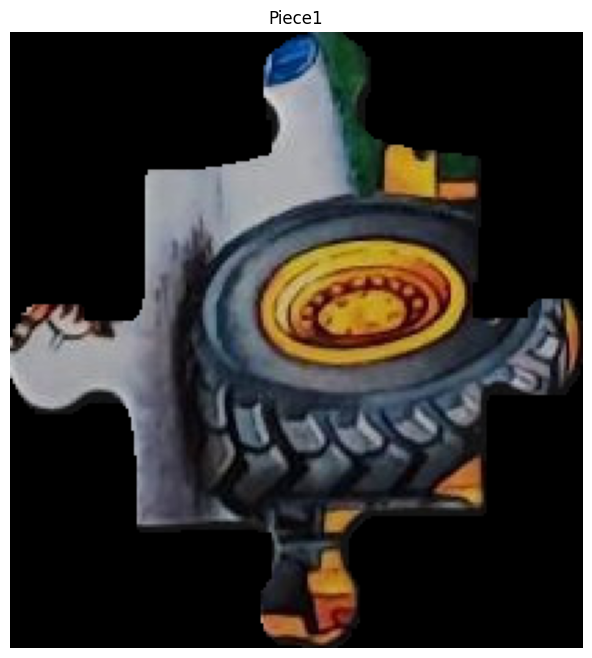

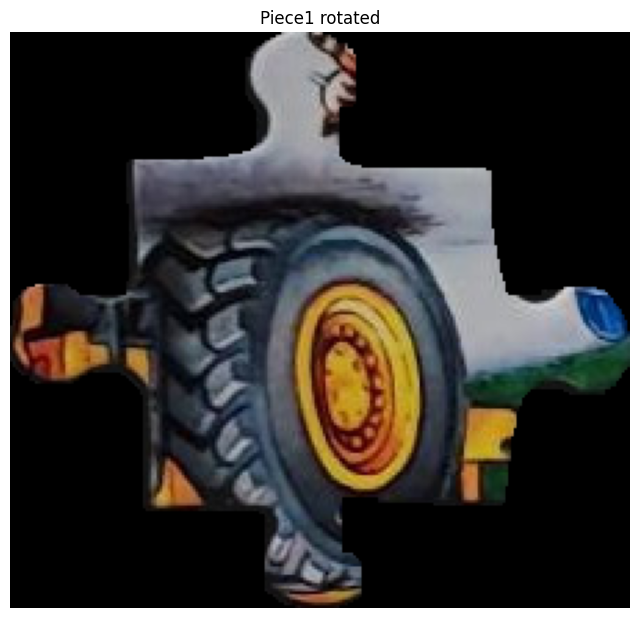

In [106]:
# Test block
print(len(puzzle_piece_holder))
print(puzzle_piece_holder[0])
print(puzzle_piece_holder[0].path)
print(puzzle_piece_holder[0].get_piece_type())
display_image("Piece1", cv2.imread(puzzle_piece_holder[0].path))
puzzle_piece_holder[0].rotate()
display_image("Piece1 rotated", cv2.imread(puzzle_piece_holder[0].path))


## Defining the matrix of pieces

In [107]:
# Find multipliers
n = len(puzzle_piece_holder)
pairs = []
for i in range(1, int(n**0.5) + 1):
    if n % i == 0:
        pairs.append((i, n // i))

print("pairs: ",pairs)

# Find the number of border pieces
n_border_pieces = [piece for piece in puzzle_piece_holder if piece.get_piece_type() == "Border"]
print("Number of border pieces: ", len(n_border_pieces))

# Get the right pair
for pair in pairs:
    if len(n_border_pieces) == (pair[0] + pair[1]) * 2 - 8:
        print(f"Pair found: {pair}")
        break

# Define width and height
WIDTH = pair[0]
HEIGHT = pair[1]
puzzle_piece_matrix = np.empty((HEIGHT, WIDTH), dtype=object)
print(puzzle_piece_matrix)

pairs:  [(1, 24), (2, 12), (3, 8), (4, 6)]
Number of border pieces:  12
Pair found: (4, 6)
[[None None None None]
 [None None None None]
 [None None None None]
 [None None None None]
 [None None None None]
 [None None None None]]


## Array of matchings
Matching model: (piece1,piece2,edge1,edge2,score) \
Edge model: (index,point1,point2,type:{0: "FLAT", 1: "IN", 2: "OUT"})

[(0, np.int64(0), np.int64(128), 0), (1, np.int64(128), np.int64(314), 1), (2, np.int64(314), np.int64(507), 1), (3, np.int64(507), np.int64(0), 0)]


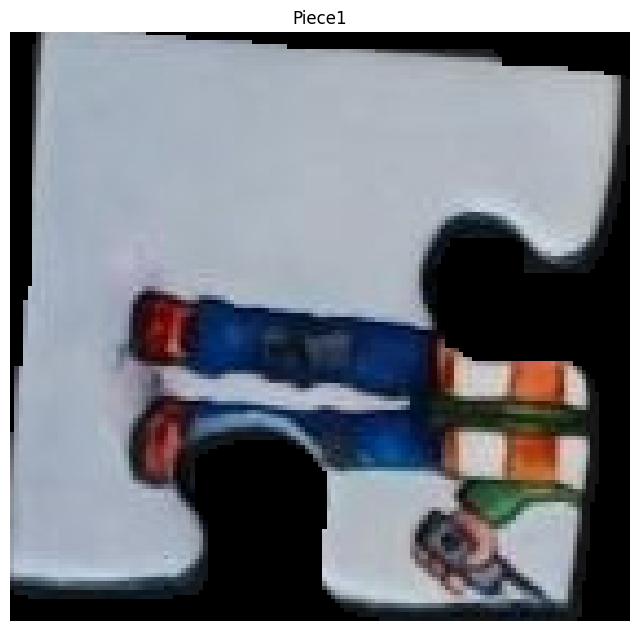

(3, np.int64(507), np.int64(0), 0)
[(0, np.int64(0), np.int64(184), 2), (1, np.int64(184), np.int64(363), 1), (2, np.int64(363), np.int64(550), 2), (3, np.int64(550), np.int64(0), 0)]


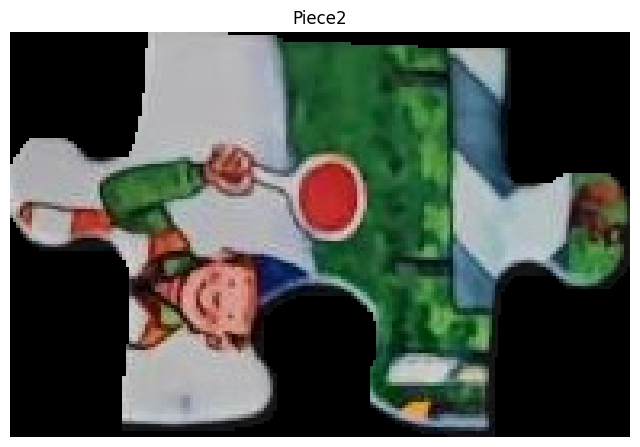

(0, np.int64(0), np.int64(184), 2)


In [108]:
# Assuming puzzle_piece_holder is a list of puzzlePiece objects
matchings = [
     (
        next((piece for piece in puzzle_piece_holder if piece.piece_id == 19), None),
        next((piece for piece in puzzle_piece_holder if piece.piece_id == 18), None),
        (2, np.int64(314), np.int64(507), 1),
        (0, np.int64(0), np.int64(184), 2),
        1
    )
]

print(matchings[0][0].edges)
display_image("Piece1", cv2.imread(matchings[0][0].path))

print(matchings[0][0].top)

print(matchings[0][1].edges)
display_image("Piece2", cv2.imread(matchings[0][1].path))

print(matchings[0][1].left)

## Matrix of pieces population
Edge model: (index,point1,point2,type:{0: "FLAT", 1: "IN", 2: "OUT"})

In [119]:
"""
Placing the corner pieces in the matrix
"""
# Put the first corner piece at the bottom left corner

puzzle_piece_matrix[HEIGHT - 1][0] = next((piece for piece in puzzle_piece_holder if piece.piece_id == 19), None) 

puzzle_piece_matrix[HEIGHT - 1][0].set_sides()
print("Bottom:",puzzle_piece_matrix[HEIGHT - 1][0].bottom[3])

while puzzle_piece_matrix[HEIGHT - 1][0].bottom[3] != 0:
    puzzle_piece_matrix[HEIGHT - 1][0].set_sides()
    print(puzzle_piece_matrix[HEIGHT - 1][0].bottom[3])
    puzzle_piece_matrix[HEIGHT - 1][0].rotate()

# Pretty print the puzzle_piece_matrix
print("Puzzle Piece Matrix:")
for row in puzzle_piece_matrix:
    print([str(piece.piece_id) if piece else "None" for piece in row])

Bottom: 1
1
Puzzle Piece Matrix:
['None', 'None', 'None', 'None']
['None', 'None', 'None', 'None']
['None', 'None', 'None', 'None']
['None', 'None', 'None', 'None']
['None', 'None', 'None', 'None']
['19', 'None', 'None', 'None']


## Canvas display
Notes:
- Pieces must be resized to 200,200 (free parameter)
- Keep a margin of 100,100 (free parameter)

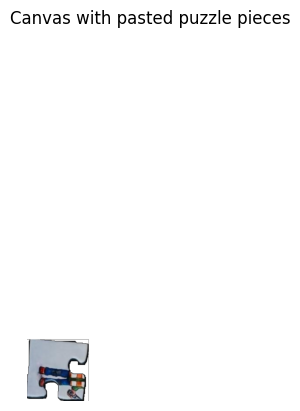

In [120]:
RESIZE = 200
canvas = np.ones((HEIGHT * RESIZE, WIDTH * RESIZE, 4)) * 255
top_left_x, top_left_y = 0, 0  # Position of top left piece

cursor_x = top_left_x
cursor_y = top_left_y

for i in range(0, len(puzzle_piece_matrix)):
    for j in range(0, len(puzzle_piece_matrix[i])):
        if type(puzzle_piece_matrix[i, j]) == puzzlePiece:
            piece = cv2.imread(puzzle_piece_matrix[i, j].path, cv2.IMREAD_UNCHANGED)
            piece = cv2.resize(piece, (RESIZE, RESIZE))

            # Transparent background
            alpha_channel = np.ones((piece.shape[0], piece.shape[1]), dtype=np.uint8) * 255
            mask = np.all(piece == [0, 0, 0], axis=-1)
            alpha_channel[mask] = 0
            piece = np.dstack((piece, alpha_channel))

            # Define the position of piece in canvas
            canvas[cursor_y:cursor_y + piece.shape[0], cursor_x:cursor_x + piece.shape[1]] = piece

        if j < WIDTH - 1:
            cursor_x += 200

    cursor_x = top_left_x
    cursor_y += 200

# Display the updated canvas
plt.imshow(cv2.cvtColor(canvas.astype(np.uint8), cv2.COLOR_BGRA2RGBA))
plt.title("Canvas with pasted puzzle pieces")
plt.axis("off")
plt.show()